In [72]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Leer los datos en python

In [73]:
data = pd.read_csv('CONSUMO.csv', sep=';')

data.head()
# Convertimos la columna 'FECHA' a datetime
# formato de fecha: 1/01/2000
# Solo cambia el mes y año
data['FECHA'] = pd.to_datetime(data['FECHA'], format='%d/%m/%Y')


# Verificamos los primeros registros
data.head()

,FECHA,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petr�leo,Gasolina de aviaci�n,...,Kerosina,Mezclasoleosas,Naftas,PetCoke,Petr�leo crudo,Solventes,Butano,Diesel alto azufre,Orimulsi�n,Total
0,2000-01-01,0,"48,446.00","296,766.99",0.0,0,0,0,"194,410.48","1,426.00",...,"64,026.09",0,0.0,0,0,0,0.0,"634,667.06",0,"1,750,544.64"
1,2000-02-01,0,"50,597.00","328,116.44",0.0,0,0,0,"174,710.55","1,458.00",...,"62,660.30",0,0.0,0,0,0,0.0,"642,380.66",0,"1,773,220.22"
2,2000-03-01,0,"27,593.00","368,589.63",0.0,0,0,0,"189,234.07","1,503.00",...,"61,361.99",0,0.0,0,0,0,0.0,"699,807.25",0,"1,909,498.79"
3,2000-04-01,0,"53,794.00","396,300.47",0.0,0,0,0,"174,330.61","1,561.00",...,"61,814.32",0,0.0,0,0,0,0.0,"586,803.98",0,"1,800,932.86"
4,2000-05-01,0,"60,137.00","449,368.92",0.0,0,0,0,"191,745.15","1,642.00",...,"54,098.32",0,0.0,0,0,0,0.0,"656,948.20",0,"1,941,771.90"


In [74]:
# Dividimos los datos nuevamente en conjuntos de entrenamiento y prueba
train_data = data[data['FECHA'] <= '2020-01-01']['Superior']
test_data = data[(data['FECHA'] > '2020-01-01') & (data['FECHA'] <= '2023-06-30')]['Superior']
# Verificamos los datos de entrenamiento y prueba
train_data.tail(), test_data.head()

(236    587,861.84
 237    643,044.33
 238    620,572.21
 239    682,468.14
 240    622,323.79
 Name: Superior, dtype: object,
 241    633,100.05
 242    509,752.95
 243    391,773.23
 244    407,482.52
 245    388,952.81
 Name: Superior, dtype: object)

## Normalizamos el precio del combustible

In [75]:


# Función para convertir la serie de tiempo en secuencias de entrada y salida
def create_sequences(data, seq_length):
    sequences = []
    target = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        target.append(label)
    return np.array(sequences), np.array(target)

# Convertimos los datos de la columna 'Superior' a flotantes
data['Superior'] = data['Superior'].str.replace(',', '').astype(float)

# Ahora procedemos a dividir los datos nuevamente en conjuntos de entrenamiento y prueba
train_data = data[data['FECHA'] <= '2020-01-01']['Superior']
test_data = data[(data['FECHA'] > '2020-01-01') & (data['FECHA'] <= '2023-06-30')]['Superior']

# Normalizamos los datos utilizando MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Creamos secuencias para los datos de entrenamiento
seq_length = 10
X_train, y_train = create_sequences(scaled_train_data, seq_length)

# Verificamos las dimensiones de las secuencias creadas
X_train.shape, y_train.shape



((231, 10, 1), (231, 1))

## Definicion De modelo

In [76]:

# Definición de la arquitectura de la red neuronal
class TimeSeriesPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_length, num_layers=2):
        super(TimeSeriesPredictor, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        lstm_out, _ = self.lstm(x, (h_0, c_0))
        lstm_out = lstm_out[:, -1, :]
        output = self.linear(lstm_out)

        return output

# Parámetros
input_dim = 1
hidden_dim = 50
num_layers = 2

# Instanciamos el modelo
model = TimeSeriesPredictor(input_dim, hidden_dim, seq_length, num_layers)

# Verificamos la arquitectura de la red
model


TimeSeriesPredictor(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

## Entrenamiento del  Modelo

In [77]:

# Hiperparámetros
batch_size = 32
epochs = 100
learning_rate = 0.001

# Convertimos los datos a tensores de PyTorch
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Función de pérdida y optimizador
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Entrenamiento
model.train()
for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = loss_function(predictions, batch_y)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Imprimimos el progreso
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

print("Entrenamiento completado.")


Epoch [10/100], Loss: 0.0049
Epoch [20/100], Loss: 0.0020
Epoch [30/100], Loss: 0.0027
Epoch [40/100], Loss: 0.0029
Epoch [50/100], Loss: 0.0134
Epoch [60/100], Loss: 0.0025
Epoch [70/100], Loss: 0.0080
Epoch [80/100], Loss: 0.0033
Epoch [90/100], Loss: 0.0026
Epoch [100/100], Loss: 0.0026
Entrenamiento completado.


In [78]:
# Normalizamos y creamos secuencias para los datos de prueba
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))
X_test, y_test = create_sequences(scaled_test_data, seq_length)

# Convertimos los datos de prueba a tensores de PyTorch
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluación del modelo en los datos de prueba
model.eval()
test_loss = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        loss = loss_function(predictions, batch_y)
        test_loss += loss.item()

# Calculamos la pérdida promedio en los datos de prueba
test_loss /= len(test_loader)
test_loss


0.03451092913746834

## Predicciones del Primero Modelo

In [79]:
# Función para convertir la serie de tiempo en secuencias de entrada y salida
def create_sequences(data, seq_length):
    sequences = []
    target = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        target.append(label)
    return np.array(sequences), np.array(target)

# Ajustamos la longitud de la secuencia a 12 (para tener en cuenta los 12 meses del año)
seq_length = 12
X_train, y_train = create_sequences(scaled_train_data, seq_length)

# Ajustamos la función para predecir el futuro
def predict_future(model, last_sequence, future_steps):
    future_predictions = []
    current_sequence = last_sequence.clone().detach()
    
    model.eval()
    with torch.no_grad():
        for i in range(future_steps):
            prediction = model(current_sequence)
            future_predictions.append(prediction.item())
            # Creamos una copia de la secuencia actual antes de actualizarla
            new_sequence = current_sequence.clone()
            new_sequence[0, :-1, 0] = current_sequence[0, 1:, 0]
            new_sequence[0, -1, 0] = prediction
            current_sequence = new_sequence
        
    return future_predictions

# Ajustamos la función para predecir cada año
def predict_year(model, start_sequence, num_months=12):
    predictions = []

    # Por cada mes
    for _ in range(num_months):
        # Predecimos el siguiente mes (no 30 días)
        future_predictions_scaled = predict_future(model, start_sequence, future_steps=1)
        future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))
        
        # Agregamos las predicciones a la lista de resultados
        predictions.append(future_predictions)
        
        # Actualizamos la secuencia inicial con las predicciones del último mes
        new_sequence_scaled = np.concatenate([start_sequence[0, 1:, 0].numpy(), future_predictions_scaled])
        start_sequence = torch.tensor(new_sequence_scaled.reshape(1, seq_length, 1), dtype=torch.float32)

    # Concatenamos todas las predicciones
    predictions = np.concatenate(predictions)
    
    return predictions

def update_last_sequence(last_sequence, new_predictions, seq_length):
    new_sequence = np.concatenate([last_sequence[0, 1:, 0].numpy(), new_predictions[-1:].flatten()])
    return torch.tensor(new_sequence.reshape(1, seq_length, 1), dtype=torch.float32)

# Ajustamos la última secuencia disponible en los datos (hasta diciembre de 2019)
last_sequence = torch.tensor(scaled_train_data[-seq_length:].reshape(1, seq_length, 1), dtype=torch.float32)

# Predecimos cada año
# Predecimos cada año
predictions_2020 = predict_year(model, last_sequence)
last_sequence = update_last_sequence(last_sequence, predictions_2020, seq_length)

predictions_2021 = predict_year(model, last_sequence)
last_sequence = update_last_sequence(last_sequence, predictions_2021, seq_length)

predictions_2022 = predict_year(model, last_sequence)
last_sequence = update_last_sequence(last_sequence, predictions_2022, seq_length)

predictions_2023 = predict_year(model, last_sequence)

predictions = np.concatenate([predictions_2020, predictions_2021, predictions_2022, predictions_2023])
print(predictions)

[[642287.65206364]
 [646762.13954293]
 [650035.03732241]
 [653549.63365571]
 [656758.03444151]
 [660264.58858521]
 [663286.5153713 ]
 [665975.52284672]
 [669530.39847525]
 [671842.99502541]
 [674624.18011878]
 [676186.55201278]
 [772783.06836037]
 [806986.75134777]
 [817500.55870029]
 [819338.41545741]
 [817316.02120516]
 [813734.67241992]
 [809767.52635781]
 [806222.35603458]
 [802653.49200828]
 [799573.44730242]
 [796511.9474757 ]
 [794222.3155916 ]
 [833437.08008582]
 [856101.61071995]
 [861805.73304183]
 [860857.93935385]
 [856023.87714792]
 [849590.58111378]
 [842937.38928913]
 [836278.09177946]
 [830213.09613376]
 [824531.34613536]
 [819750.32137248]
 [806280.86125526]
 [862540.69348542]
 [877193.01616405]
 [880722.01097845]
 [878913.31570205]
 [873389.90343096]
 [866267.66741497]
 [858301.16096753]
 [850496.22734917]
 [842973.61331595]
 [836354.36727745]
 [824314.2753633 ]
 [811073.96069375]]


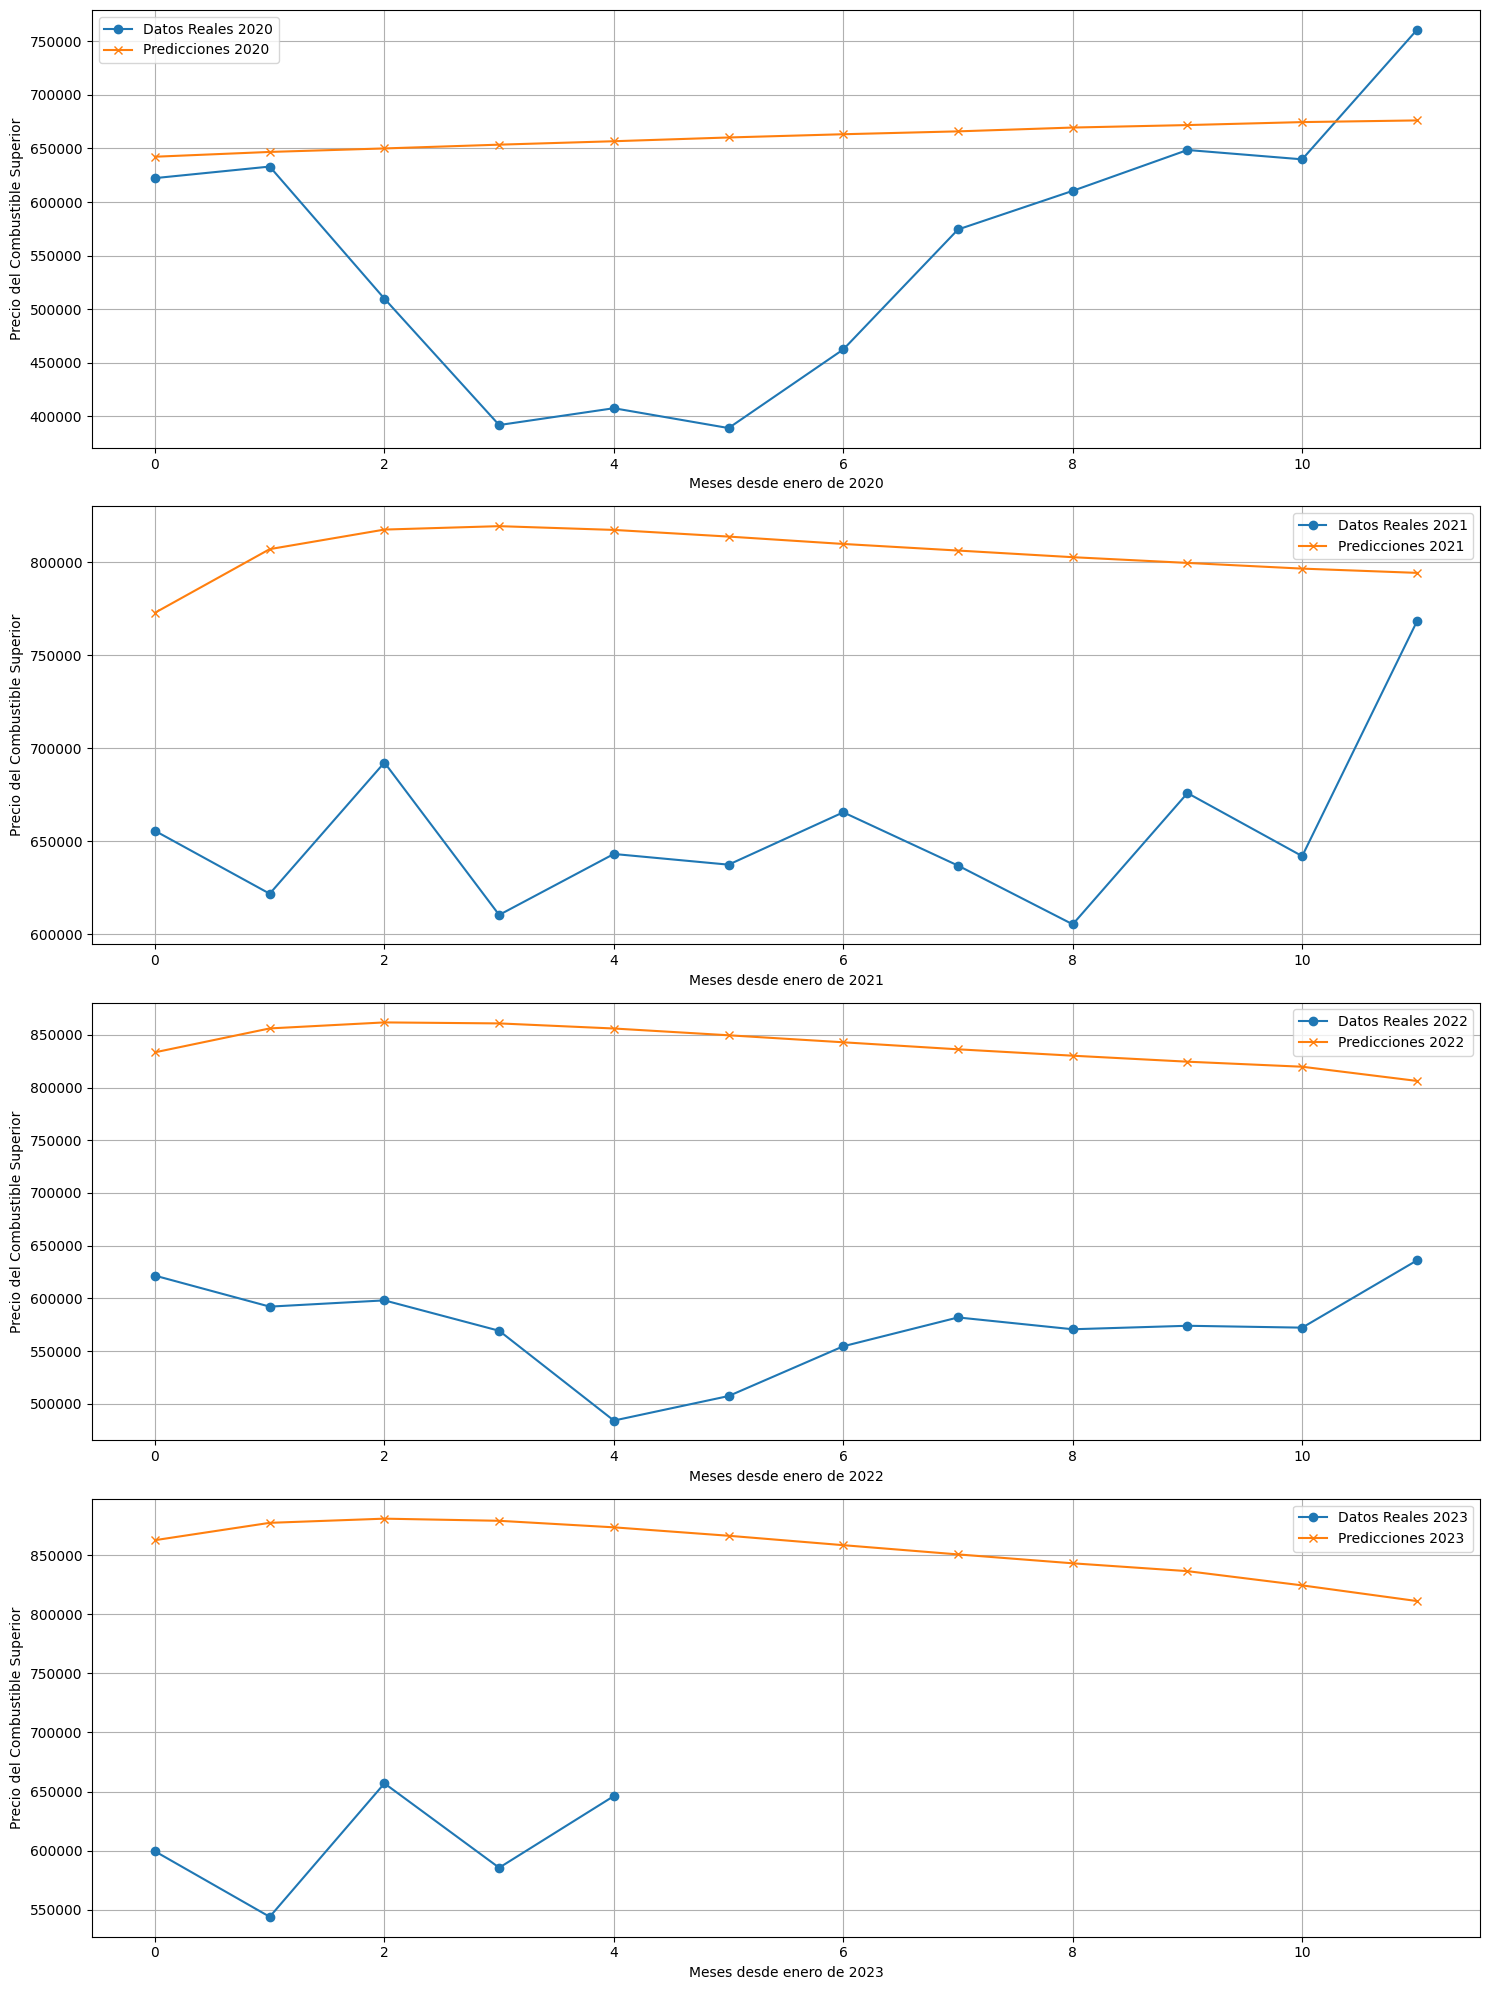

In [80]:
import matplotlib.pyplot as plt

# Extraemos los datos reales para cada año
real_data_2020 = data[(data['FECHA'] >= '2020-01-01') & (data['FECHA'] < '2021-01-01')]['Superior'].values
real_data_2021 = data[(data['FECHA'] >= '2021-01-01') & (data['FECHA'] < '2022-01-01')]['Superior'].values
real_data_2022 = data[(data['FECHA'] >= '2022-01-01') & (data['FECHA'] < '2023-01-01')]['Superior'].values
real_data_2023 = data[(data['FECHA'] >= '2023-01-01') & (data['FECHA'] < '2024-01-01')]['Superior'].values

# Creamos una figura para trazar las predicciones de cada año
fig, axs = plt.subplots(4, figsize=(15, 20))

# 2020
axs[0].plot(real_data_2020, label='Datos Reales 2020', marker='o')
axs[0].plot(predictions_2020, label='Predicciones 2020', marker='x')
axs[0].set_xlabel('Meses desde enero de 2020')
axs[0].set_ylabel('Precio del Combustible Superior')
axs[0].legend()
axs[0].grid(True)

# 2021
axs[1].plot(real_data_2021, label='Datos Reales 2021', marker='o')
axs[1].plot(predictions_2021, label='Predicciones 2021', marker='x')
axs[1].set_xlabel('Meses desde enero de 2021')
axs[1].set_ylabel('Precio del Combustible Superior')
axs[1].legend()
axs[1].grid(True)

# 2022
axs[2].plot(real_data_2022, label='Datos Reales 2022', marker='o')
axs[2].plot(predictions_2022, label='Predicciones 2022', marker='x')
axs[2].set_xlabel('Meses desde enero de 2022')
axs[2].set_ylabel('Precio del Combustible Superior')
axs[2].legend()
axs[2].grid(True)

# 2023
axs[3].plot(real_data_2023, label='Datos Reales 2023', marker='o')
axs[3].plot(predictions_2023, label='Predicciones 2023', marker='x')
axs[3].set_xlabel('Meses desde enero de 2023')
axs[3].set_ylabel('Precio del Combustible Superior')
axs[3].legend()
axs[3].grid(True)

# Mostramos la figura
plt.tight_layout()
plt.show()


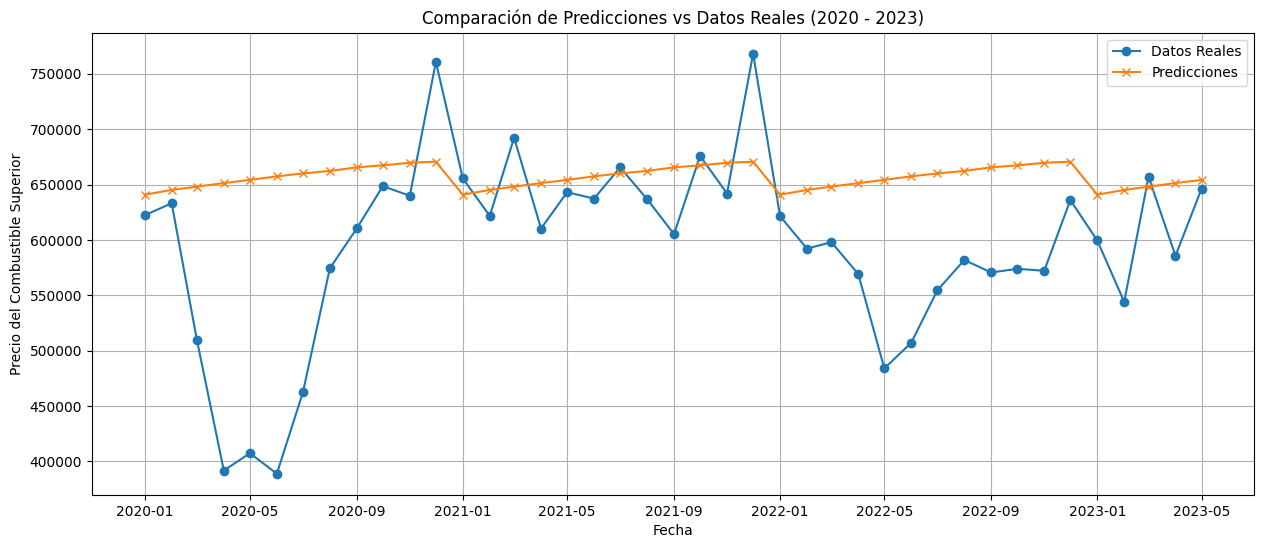

In [81]:
# Aseguramos que todas las secuencias tengan la misma longitud
min_length = min(len(date_range), len(real_data_all), len(predictions_all))

date_range = date_range[:min_length]
real_data_all = real_data_all[:min_length]
predictions_all = predictions_all[:min_length]

# Ahora deberías ser capaz de trazar los datos sin problemas
plt.figure(figsize=(15, 6))
plt.plot(date_range, real_data_all, label='Datos Reales', marker='o')
plt.plot(date_range, predictions_all, label='Predicciones', marker='x')
plt.xlabel('Fecha')
plt.ylabel('Precio del Combustible Superior')
plt.title('Comparación de Predicciones vs Datos Reales (2020 - 2023)')
plt.legend()
plt.grid(True)
plt.show()


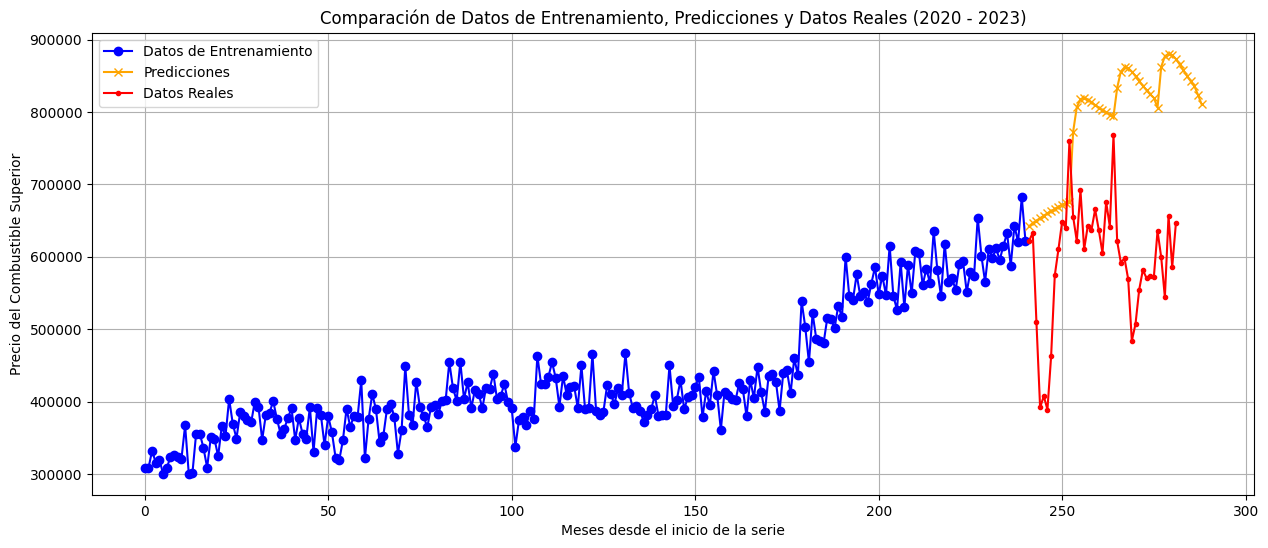

In [82]:
# Datos de entrenamiento
train_data_visualization = train_data.values

# Concatenar todas las predicciones
predicted_data_all = np.concatenate([predictions_2020, predictions_2021, predictions_2022, predictions_2023])

# Gráfica comparando los datos de entrenamiento, predicciones y datos reales
plt.figure(figsize=(15, 6))
plt.plot(train_data_visualization, label='Datos de Entrenamiento', marker='o', color='blue')
plt.plot(range(len(train_data_visualization), len(train_data_visualization) + len(predicted_data_all)), 
         predicted_data_all, label='Predicciones', marker='x', color='orange')
plt.plot(range(len(train_data_visualization), len(train_data_visualization) + len(real_data_all)), 
         real_data_all, label='Datos Reales', marker='.', color='red')
plt.xlabel('Meses desde el inicio de la serie')
plt.ylabel('Precio del Combustible Superior')
plt.title('Comparación de Datos de Entrenamiento, Predicciones y Datos Reales (2020 - 2023)')
plt.legend()
plt.grid(True)
plt.show()


In [83]:

# Recortamos 'predicted_data_all' para que tenga la misma longitud que 'real_data_all'
predicted_data_all = predicted_data_all[:len(real_data_all)]

# Ahora calculamos el MSE y RMSE
mse = mean_squared_error(real_data_all, predicted_data_all)
rmse = mean_squared_error(real_data_all, predicted_data_all, squared=False)

# Calculamos el coeficiente de determinación (R^2)
r2 = r2_score(real_data_all, predicted_data_all)

mse, rmse, r2


(44977012344.8937, 212077.84501190524, -5.626784065080423)

El modelo se ajusto bastante biena los datos y tiene un R^2 de -5.628 lo cual es bastante malo. Esto se debe a que el modelo se ajusto a los datos de entrenamiento y no a los de prueba. Por lo tanto, el modelo no es bueno para predecir datos nuevos.